In [22]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import DataLoader, TensorDataset, random_split
import pyswarms as ps
import pygad
import math

## 2D Ackley Approximation

In [7]:
# 2D
def Ackley(X): 
    Z = -20.0 * np.exp(-0.2 * np.sqrt(0.5 * (X[0]**2 + X[1]**2)))-np.exp(0.5 * (math.cos(2 * np.pi * X[0])+math.cos(2 * np.pi * X[1]))) + np.exp(1) + 20
    return Z

In [8]:
def generate_data(num_points):
    points = np.random.uniform(-5,5, size=(num_points, 2))
    func_out = Ackley(points)
    return points, func_out


In [9]:
def plot3d(xy,func_out):
    xy = np.array(xy)
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca(projection='3d')
    ax.scatter(xy[:,0], xy[:,1], func_out)
    plt.show()

In [10]:
def plot2d(xy):
    xy = np.array(xy)
    fig = plt.figure(figsize=(16,8))
    plt.scatter(xy[:,0],xy[:,1])

In [11]:
class Model_2D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Linear1 = nn.Linear(2,20)
        self.Linear2 = nn.Linear(20,50)
        self.Linear3= nn.Linear(50,120)   
        self.Linear4 = nn.Linear(120,70) 
        self.Linear5 = nn.Linear(70,20)  
        self.Linear6= nn.Linear(20,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        X = self.Relu(self.Linear5(X))
        X = self.Relu(self.Linear6(X))  
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 
                        


In [26]:
def train(model,train_loader,test_loader,checkpoint_path,num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = num_epochs
    best_loss = 100
    batch_size = 8
    PATH = checkpoint_path
    train_loss_list = []
    test_loss_list = []
    for epoch in range(1,num_epochs+1):  # loop over the dataset multiple times
        running_loss = 0.0
        running_loss_test = 0.0
        for batch in train_loader:
            inputs, targets = batch
            optimizer.zero_grad()
            # forward pass
            outputs = model(inputs)
            # loss computation
            loss = criterion(outputs.squeeze(),targets) * 100
            # backward pass
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        print("Epoch {}/{}, Loss: {} ".format(epoch,num_epochs,running_loss/(len(train_loader)*batch_size)))
        
        train_loss_list.append(running_loss/(len(train_loader)*batch_size))   
        
        with torch.no_grad():
            for batch in test_loader:   # loop over the test dataset
                inputs, targets = batch
                outputs = model(inputs)
                # loss computation
                loss_test = criterion(outputs.squeeze(),targets) * 100
                running_loss_test += loss_test.item()
                
            avg_loss = running_loss_test/(len(test_loader)*batch_size)
            test_loss_list.append(avg_loss)
            
            if avg_loss < best_loss:
                best_loss = avg_loss
                torch.save(model.state_dict(), PATH)
                
    return [train_loss_list, test_loss_list]
    

       

In [27]:
def compute(X,Y,func):
    pred_array = np.zeros((50,50))
    for i in range(len(X)):
        for j in range(len(Y)):
            pred = func(np.array([[X[i],Y[j]]]))
            pred_array[j,i] = pred
    return pred_array

In [40]:
def compute_func(X,Y,func):
    pred_array = np.zeros((50,50))
    for i in range(len(X)):
        for j in range(len(Y)):
            pred = func(np.array([X[i],Y[j]]))
            pred_array[j,i] = pred
    return pred_array

In [41]:
def plot_contours(model,pt):
    
    X = np.linspace(-5,5,50)
    Y = np.linspace(-5,5,50)
    Z1 = compute_func(X,Y,Ackley)
    Z2 = compute(X,Y,model)
    X,Y = np.meshgrid(X,Y)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.contourf(X,Y,Z1,20, cmap='RdGy')
    ax1.scatter(0,0) #actual minima
    ax2.contourf(X,Y,Z2,20, cmap='RdGy')
    ax2.scatter(0,0) #actual minima
    ax2.scatter(pt[0],pt[1])  
    plt.tight_layout() 
    plt.show()



In [29]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-5,5, size=(num_points, 2))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-5,5, size=(num_points_sparse, 2))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((2)) * 5/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 2])
        
    func_out = np.array([Ackley(p) for p in points])
    return points, func_out


In [30]:
def get_loaders_types(data_type):
    inputs_array, targets_array = generate_data_types(10000,[0,0], data_type)
    plot2d(inputs_array)
    plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader


In [31]:
def apply_swarm(model, dimension,i):
    # Create bounds
    np.random.seed(i)
    max_bound = np.ones(dimension) * 5
    min_bound = - max_bound
    bounds = (min_bound, max_bound)
    # Initialize swarm
    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9} 

    # Call instance of PSO with bounds argument
    optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimension, options=options, bounds=bounds)

    # Perform optimization
    cost, pos = optimizer.optimize(model, iters=1000)
    
    return pos

In [32]:
def apply_GA(model,dimension,i):
    Y = 0 

    def Fitness_func(solution, solution_idx):
        out = model(solution)
        fittness = 1.0 / (np.abs(out - Y) + 0.000001)
        return fittness

    
    ga_instance = pygad.GA(num_generations=100,    #mention setting in paper
                           num_parents_mating=2,
                           sol_per_pop=10,
                           num_genes=dimension,
                           fitness_func=Fitness_func,
                           init_range_low=-5,
                           init_range_high=5,
                           parent_selection_type="sss",
                       )
    np.random.seed(i)
    ga_instance.run()
    
    solution, solution_fittness, solution_idx = ga_instance.best_solution()
#     fig = ga_instance.plot_result()
#     plt.show()
    return solution

In [33]:
def apply_Optim_mean(dimension,model):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(5):
        pos = apply_swarm(model,dimension,np.random.randint(0,100))
        sol = apply_GA(model,dimension,np.random.randint(0,100))
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list

In [34]:
def apply_Optim_mean_for_calc(dimension,model):
    sol_swarm_list = []
    sol_GA_list = []
    for i in range(10):
        pos = apply_swarm(model,dimension,np.random.randint(0,100))
        sol = apply_GA(model,dimension,np.random.randint(0,100))
        sol_swarm_list.append(pos)
        sol_GA_list.append(sol)
    return sol_swarm_list,sol_GA_list

# Dense

/tmp/ipykernel_3152921/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


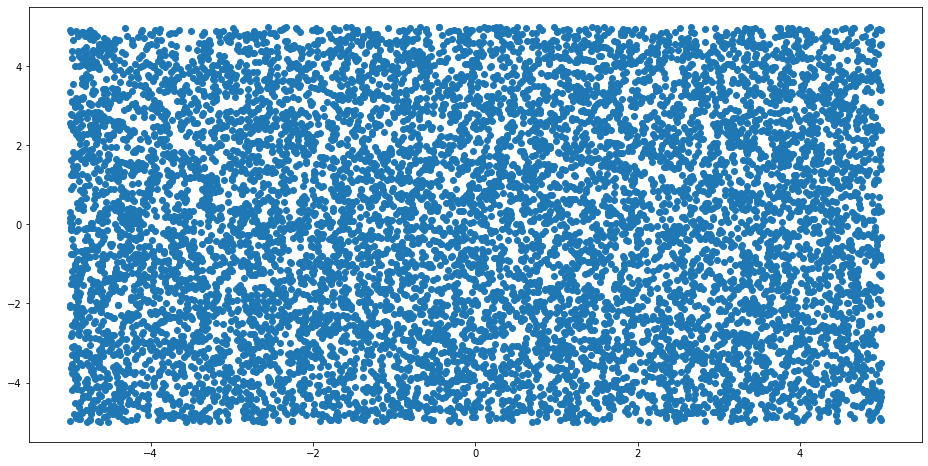

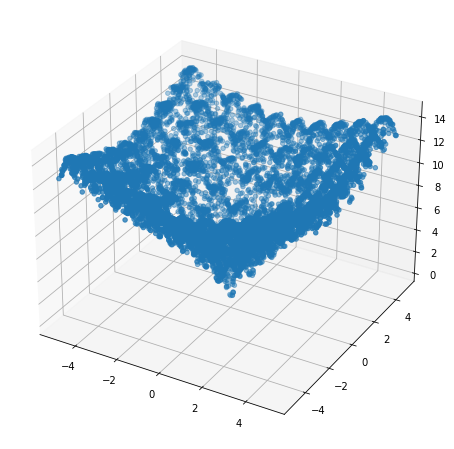

Epoch 1/500, Loss: 68.2023341296221 
Epoch 2/500, Loss: 5.927034093691217 
Epoch 3/500, Loss: 5.589028470973285 
Epoch 4/500, Loss: 5.398828080960988 
Epoch 5/500, Loss: 5.218288056359216 
Epoch 6/500, Loss: 5.025029575666287 
Epoch 7/500, Loss: 5.0165044984775795 
Epoch 8/500, Loss: 4.80538482593227 
Epoch 9/500, Loss: 4.761267483070509 
Epoch 10/500, Loss: 4.823177758046354 
Epoch 11/500, Loss: 4.717369482898724 
Epoch 12/500, Loss: 4.630219268900227 
Epoch 13/500, Loss: 4.751803373737525 
Epoch 14/500, Loss: 4.657906314532959 
Epoch 15/500, Loss: 4.602245355276957 
Epoch 16/500, Loss: 4.567017415204236 
Epoch 17/500, Loss: 4.512969677467292 
Epoch 18/500, Loss: 4.665132085865605 
Epoch 19/500, Loss: 4.716508397398989 
Epoch 20/500, Loss: 4.616622177570848 
Epoch 21/500, Loss: 4.528646926979255 
Epoch 22/500, Loss: 4.653002020318637 
Epoch 23/500, Loss: 4.578440027025719 
Epoch 24/500, Loss: 4.6075107516315565 
Epoch 25/500, Loss: 4.544659359015129 
Epoch 26/500, Loss: 4.621473184065

In [35]:
model_dense = Model_2D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Ackley_dense.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [36]:
PATH_dense = "Ackley_dense.pth"
model_dense = Model_2D().double()
model_dense.load_state_dict(torch.load(PATH_dense))

<All keys matched successfully>

In [37]:
ls1,ls2 = apply_Optim_mean(2,model_dense)
ls1

2022-09-25 21:02:28,200 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.314
2022-09-25 21:02:30,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3140065488499073, best pos: [-0.02638069  0.01077378]
/home/fatima.albreiki/.conda/envs/CV703/lib/python3.9/site-packages/pygad/pygad.py:473: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(

[array([-0.02638069,  0.01077378]),
 array([-0.02638069,  0.01077378]),
 array([-0.02638069,  0.01077378]),
 array([-0.02638069,  0.01077378]),
 array([-0.02638069,  0.01077378])]

In [ ]:
ls2

[array([0.05954809, 0.02586578]),
 array([0.02357422, 0.03019915]),
 array([0.05322097, 0.0247837 ]),
 array([0.05102734, 0.02699523]),
 array([0.05645343, 0.02722124])]

In [44]:
def plot_contours_modified(model,PS_list,GA_list):
    
    X = np.linspace(-4,4,50)
    Y = np.linspace(-4,4,50)
    Z1 = compute_func(X,Y,Ackley)
    Z2 = compute(X,Y,model)
    Z3 = Z2
    X,Y = np.meshgrid(X,Y)
    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(10,5))
    ax1.contourf(X,Y,Z1,20, cmap='RdGy')
    ax1.scatter(0,0,color="red")
    ax2.contourf(X,Y,Z2,20, cmap='RdGy')
    ax2.scatter(0,0,color="red")
    ax2.scatter(PS_list[0][0],PS_list[0][1])  
    ax2.scatter(PS_list[1][0],PS_list[1][1])  
    ax2.scatter(PS_list[2][0],PS_list[2][1])  
    ax2.scatter(PS_list[3][0],PS_list[3][1])  
    ax2.scatter(PS_list[4][0],PS_list[4][1])
    ax3.contourf(X,Y,Z3,20, cmap='RdGy')
    ax3.scatter(0,0,color="red")
    ax3.scatter(GA_list[0][0],GA_list[0][1])  
    ax3.scatter(GA_list[1][0],GA_list[1][1])  
    ax3.scatter(GA_list[2][0],GA_list[2][1])  
    ax3.scatter(GA_list[3][0],GA_list[3][1])  
    ax3.scatter(GA_list[4][0],GA_list[4][1]) 

    plt.tight_layout() 
    plt.show()



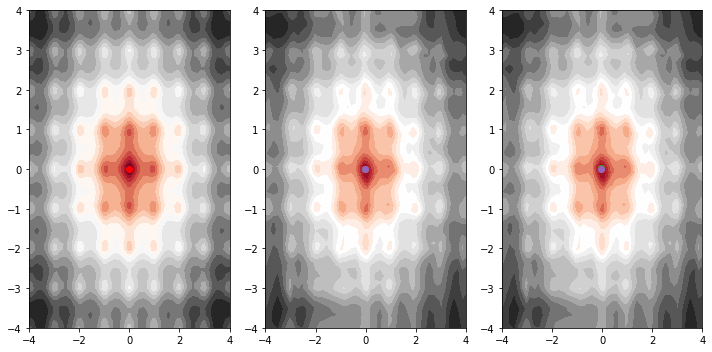

In [45]:
plot_contours_modified(model_dense,ls1,ls2)

# Sparse

/tmp/ipykernel_3152921/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


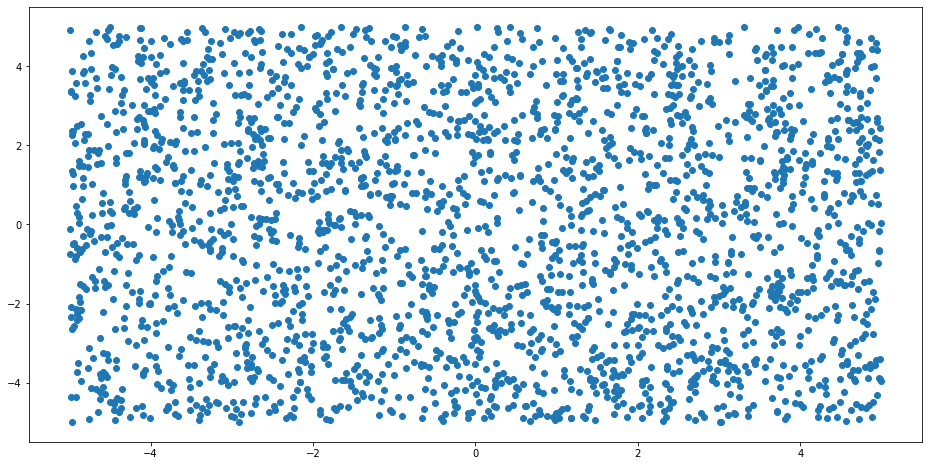

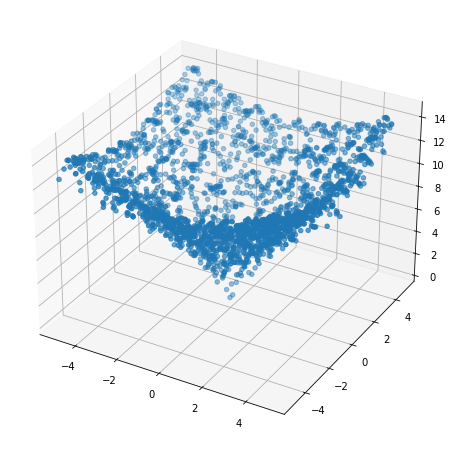

Epoch 1/500, Loss: 201.71883026259997 
Epoch 2/500, Loss: 6.715623250394246 
Epoch 3/500, Loss: 6.304461150215468 
Epoch 4/500, Loss: 6.295155967708502 
Epoch 5/500, Loss: 5.929042180789313 
Epoch 6/500, Loss: 6.153992944877651 
Epoch 7/500, Loss: 6.034080953034045 
Epoch 8/500, Loss: 6.264479847957896 
Epoch 9/500, Loss: 5.573085170290069 
Epoch 10/500, Loss: 5.8225608935831055 
Epoch 11/500, Loss: 5.757517754253966 
Epoch 12/500, Loss: 5.319164140402348 
Epoch 13/500, Loss: 5.916948784857376 
Epoch 14/500, Loss: 5.505365869282035 
Epoch 15/500, Loss: 5.549313318091707 
Epoch 16/500, Loss: 6.117484719708375 
Epoch 17/500, Loss: 5.4718813405902695 
Epoch 18/500, Loss: 5.244904835398205 
Epoch 19/500, Loss: 5.269756383783201 
Epoch 20/500, Loss: 5.250016386058868 
Epoch 21/500, Loss: 5.464164828363234 
Epoch 22/500, Loss: 5.48940421527971 
Epoch 23/500, Loss: 5.104215760027425 
Epoch 24/500, Loss: 5.361730806510381 
Epoch 25/500, Loss: 5.336474919027231 
Epoch 26/500, Loss: 5.0125845651

In [46]:
model_sparse = Model_2D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Ackley_sparse.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [48]:
PATH_sparse = "Ackley_sparse.pth"
model_sparse = Model_2D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))

<All keys matched successfully>

In [49]:
ls1_sparse,ls2_sparse = apply_Optim_mean(2,model_sparse)
ls1_sparse

2022-09-25 21:12:51,544 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.618
2022-09-25 21:12:53,305 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6182203463169983, best pos: [ 0.02239167 -0.07220116]
/home/fatima.albreiki/.conda/envs/CV703/lib/python3.9/site-packages/pygad/pygad.py:473: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate (mutation_percent_genes={mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(

[array([ 0.02239167, -0.07220116]),
 array([0.0173026 , 0.13187617]),
 array([0.13653116, 0.08457092]),
 array([0.07381312, 0.02883079]),
 array([0.12649996, 0.0220485 ])]

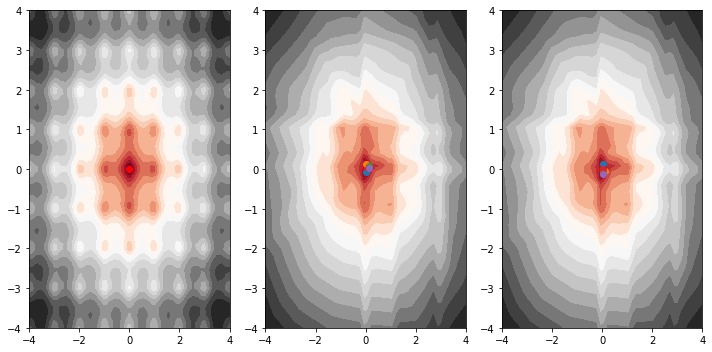

In [50]:
plot_contours_modified(model_sparse,ls1_sparse,ls2_sparse)

In [51]:
from scipy.spatial import distance

def mean_std(dimension,model):
    
    sol_swarm_list,sol_GA_list = apply_Optim_mean_for_calc(dimension,model)
    min_pt = np.zeros((dimension))
    swarm_dist = [] 
    GA_dist = []
    for i in range(10):
        swarm_dist.append(distance.euclidean(min_pt,sol_swarm_list[i]))
        GA_dist.append(distance.euclidean(min_pt,sol_GA_list[i]))
        
    mean_swarm_dist = np.mean(swarm_dist)
    std_swarm_dist = np.std(swarm_dist)
   
    mean_GA_dist= np.mean(GA_dist)
    std_GA_dist = np.std(GA_dist)
    
    return mean_swarm_dist,std_swarm_dist,mean_GA_dist,std_GA_dist
    

In [52]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(2,model_sparse)

2022-09-25 21:13:57,329 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.618
2022-09-25 21:13:59,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6182203463169983, best pos: [ 0.09943371 -0.05444448]
2022-09-25 21:13:59,513 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.618
2022-09-25 21:14:01,369 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.6182203463169983, best pos: [0.15391641 0.01065925]
2022-09-25 21:14:01,815 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.618
2022-09-25 21:14:03,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.618

In [53]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse

(0.14326292281330855,
 0.07580834985723324,
 0.13755137870457257,
 0.05355229817617226)

In [54]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(2,model_dense)

2022-09-25 21:14:19,451 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.314
2022-09-25 21:14:21,209 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3140065488499073, best pos: [-0.02638069  0.01077378]
2022-09-25 21:14:21,636 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.314
2022-09-25 21:14:23,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3140065488499073, best pos: [-0.02638069  0.01077378]
2022-09-25 21:14:23,773 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.314
2022-09-25 21:14:25,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3

In [55]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense

(0.028495879584204638,
 1.3468873883852546e-16,
 0.03395271620555228,
 0.006999137407549976)

# Gauss


/tmp/ipykernel_3152921/1547251272.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


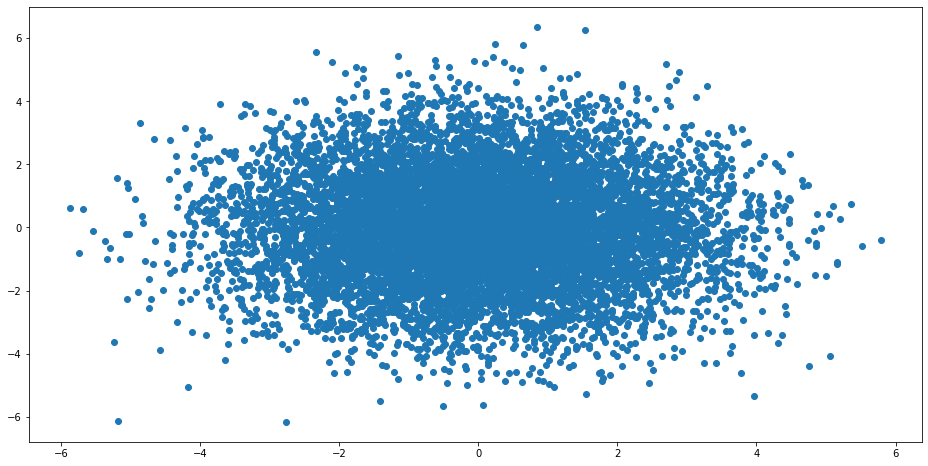

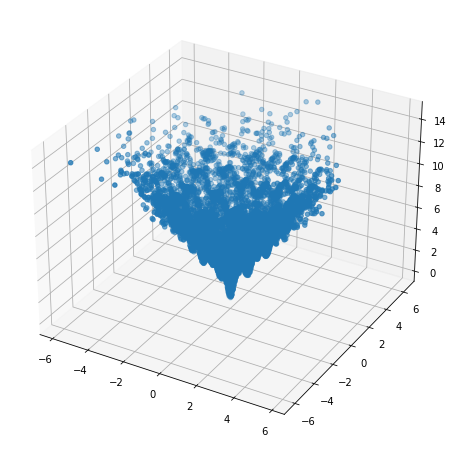

Epoch 1/500, Loss: 36.654598827332656 
Epoch 2/500, Loss: 5.1772559557843865 
Epoch 3/500, Loss: 5.092358078926058 
Epoch 4/500, Loss: 4.8847766907657615 
Epoch 5/500, Loss: 4.726652811047857 
Epoch 6/500, Loss: 4.795004988419653 
Epoch 7/500, Loss: 4.672221824139268 
Epoch 8/500, Loss: 4.556707079100744 
Epoch 9/500, Loss: 4.45909162158929 
Epoch 10/500, Loss: 4.3208863060468055 
Epoch 11/500, Loss: 4.289912635132991 
Epoch 12/500, Loss: 4.307225170748426 
Epoch 13/500, Loss: 4.15155247409233 
Epoch 14/500, Loss: 3.9950693888289144 
Epoch 15/500, Loss: 3.966819539547637 
Epoch 16/500, Loss: 3.883948976922408 
Epoch 17/500, Loss: 3.8066252450681595 
Epoch 18/500, Loss: 3.8364152687424458 
Epoch 19/500, Loss: 3.6722809338056304 
Epoch 20/500, Loss: 3.6420872533865403 
Epoch 21/500, Loss: 3.44282183234353 
Epoch 22/500, Loss: 3.5155094424387316 
Epoch 23/500, Loss: 3.4792129428396836 
Epoch 24/500, Loss: 3.3333690009894617 
Epoch 25/500, Loss: 3.275472296334129 
Epoch 26/500, Loss: 3.274

In [56]:
model_gauss = Model_2D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Ackley_gauss.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

In [57]:
PATH_gauss = "Ackley_gauss.pth"
model_gauss = Model_2D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))

<All keys matched successfully>

In [58]:
ls1_gauss,ls2_gauss = apply_Optim_mean(2,model_gauss)
ls1_gauss

2022-09-25 21:50:59,542 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.48
2022-09-25 21:51:01,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48006983701555817, best pos: [ 0.02730084 -0.0797616 ]
2022-09-25 21:51:01,622 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.48
2022-09-25 21:51:03,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48006983701555817, best pos: [0.01544155 0.02300563]
2022-09-25 21:51:03,910 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.48
2022-09-25 21:51:05,622 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4800

[array([ 0.02730084, -0.0797616 ]),
 array([0.01544155, 0.02300563]),
 array([-0.07644776, -0.04735932]),
 array([-0.09151279,  0.0040017 ]),
 array([-0.0325001 , -0.06299724])]

In [52]:
ls1_gauss,ls2_gauss

([array([0.0081677 , 0.29611606]),
  array([-0.76923234,  0.76502603]),
  array([-0.61928687,  0.33200787]),
  array([1.06914319, 1.15269791]),
  array([0.92410619, 0.77189557])],
 [array([ 0.37718372, -0.20722706]),
  array([-0.43069101,  0.28828865]),
  array([0.12725837, 0.17361494]),
  array([0.48828538, 0.23423914]),
  array([0.00161754, 0.24115592])])

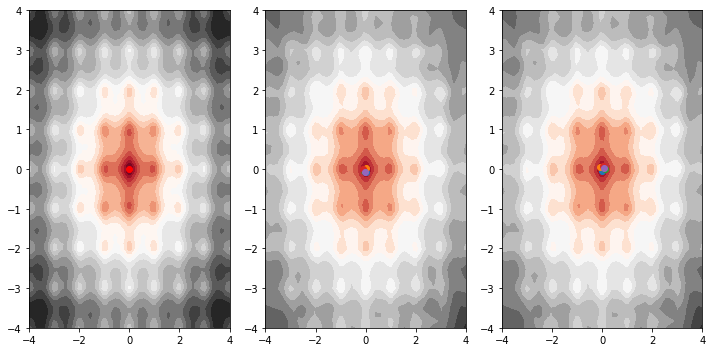

In [59]:
plot_contours_modified(model_gauss,ls1_gauss,ls2_gauss)

In [60]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(2,model_gauss)

2022-09-25 21:51:40,509 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.48
2022-09-25 21:51:42,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48006983701555817, best pos: [ 0.01837143 -0.10445532]
2022-09-25 21:51:42,667 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.48
2022-09-25 21:51:44,447 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48006983701555817, best pos: [-0.01098804 -0.04089061]
2022-09-25 21:51:44,780 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.48
2022-09-25 21:51:46,488 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.48

In [61]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss 

(0.060784657878345985,
 0.030035892059437942,
 0.06555402111492567,
 0.016856347856632214)

# 4D Ackley


In [87]:
class Model_4D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Linear1 = nn.Linear(4,20)
        self.Linear2 = nn.Linear(20,50)
        self.Linear3= nn.Linear(50,120)   
        self.Linear4 = nn.Linear(120,70) 
        self.Linear5 = nn.Linear(70,20)  
        self.Linear6= nn.Linear(20,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        X = self.Relu(self.Linear5(X))
        X = self.Relu(self.Linear6(X))  
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 

In [88]:
# 4D
def Ackley_4D(X):
    d = X.shape[0]
    Z = -20.0 * np.exp(-0.2 * np.sqrt(1/d * (X[0]**2 + X[1]**2 + X[2]**2 + X[3]**2)))-np.exp(1/d * (math.cos(2 * np.pi * X[0])+math.cos(2 * np.pi * X[1])+ math.cos(2 * np.pi * X[2])+math.cos(2 * np.pi * X[3]))) + np.exp(1) + 20
    return Z

In [89]:
def get_loaders_types(data_type):
    inputs_array, targets_array = generate_data_types(10000,[0,0,0,0], data_type)
#     plot2d(inputs_array)
#     plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader



In [90]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-5,5, size=(num_points, 4))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-5,5, size=(num_points_sparse, 4))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((4)) * 5/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 4])
        
    func_out = np.array([Ackley_4D(p) for p in points])
    return points, func_out

In [91]:
model_dense = Model_4D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Ackley_dense_4.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/500, Loss: 60.68382708213222 
Epoch 2/500, Loss: 3.0687149322006464 
Epoch 3/500, Loss: 3.060954937458766 
Epoch 4/500, Loss: 2.9842600166775437 
Epoch 5/500, Loss: 2.865953257469757 
Epoch 6/500, Loss: 2.841565871426617 
Epoch 7/500, Loss: 2.8095683610168787 
Epoch 8/500, Loss: 2.7693679430372504 
Epoch 9/500, Loss: 2.7305930040124466 
Epoch 10/500, Loss: 2.7259386971566553 
Epoch 11/500, Loss: 2.790025721403155 
Epoch 12/500, Loss: 2.6398370809084684 
Epoch 13/500, Loss: 2.731334161926818 
Epoch 14/500, Loss: 2.6564937999744136 
Epoch 15/500, Loss: 2.751140711537255 
Epoch 16/500, Loss: 2.5849333845709435 
Epoch 17/500, Loss: 2.6360530127330013 
Epoch 18/500, Loss: 2.657699595752638 
Epoch 19/500, Loss: 2.7091406247884584 
Epoch 20/500, Loss: 2.482494001783791 
Epoch 21/500, Loss: 2.4534119985951826 
Epoch 22/500, Loss: 2.4366862233756716 
Epoch 23/500, Loss: 2.315161463920272 
Epoch 24/500, Loss: 2.3808576194781335 
Epoch 25/500, Loss: 2.3603135175405505 
Epoch 26/500, Loss:

In [92]:
PATH_dense = "Ackley_dense_4.pth"
model_dense = Model_4D().double()
model_dense.load_state_dict(torch.load(PATH_dense))

<All keys matched successfully>

In [93]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(4,model_dense)

2022-09-26 00:33:14,472 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.32
2022-09-26 00:33:16,400 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.32266466511184, best pos: [-0.59184916 -0.25647644 -0.08585756  0.97175434]
2022-09-26 00:33:16,811 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.32
2022-09-26 00:33:18,769 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.32266466511184, best pos: [ 0.44107695  0.21863822 -0.30846569 -0.34721655]
2022-09-26 00:33:19,094 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.32
2022-09-26 00:33:20,618 - pyswarms.single.global_best - INFO

In [94]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense 

(0.7570300440732483,
 0.20237257337758202,
 0.9042970679695694,
 0.19796992442206504)

In [95]:
model_sparse = Model_4D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Ackley_sparse_4.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/500, Loss: 156.95824283185064 
Epoch 2/500, Loss: 4.8043943677411916 
Epoch 3/500, Loss: 3.5015919959929813 
Epoch 4/500, Loss: 3.2710564317761603 
Epoch 5/500, Loss: 2.8728642319477258 
Epoch 6/500, Loss: 2.997678853989035 
Epoch 7/500, Loss: 2.9643596646749746 
Epoch 8/500, Loss: 3.2142836744791428 
Epoch 9/500, Loss: 3.0185722179938166 
Epoch 10/500, Loss: 3.1396210879292785 
Epoch 11/500, Loss: 2.6273421498713097 
Epoch 12/500, Loss: 3.0128442120678223 
Epoch 13/500, Loss: 2.728577368224784 
Epoch 14/500, Loss: 2.9887152710496645 
Epoch 15/500, Loss: 2.7243757726091387 
Epoch 16/500, Loss: 2.923977054043334 
Epoch 17/500, Loss: 2.647665720815546 
Epoch 18/500, Loss: 2.994741129254354 
Epoch 19/500, Loss: 2.707444303185817 
Epoch 20/500, Loss: 2.735511706016957 
Epoch 21/500, Loss: 2.5806528849056236 
Epoch 22/500, Loss: 2.7529902109739512 
Epoch 23/500, Loss: 2.7707202183761788 
Epoch 24/500, Loss: 2.482318404609682 
Epoch 25/500, Loss: 2.6864961949368236 
Epoch 26/500, Los

In [96]:
PATH_sparse = "Ackley_sparse_4.pth"
model_sparse = Model_4D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))

<All keys matched successfully>

In [97]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(4,model_sparse)

2022-09-26 00:38:36,938 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.73
2022-09-26 00:38:38,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.7323341897471773, best pos: [ 0.10368683  0.09677824 -0.29985287  0.06368558]
2022-09-26 00:38:39,130 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.74
2022-09-26 00:38:41,043 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.7416277735395385, best pos: [ 0.05365256 -0.11625289  0.1237118   0.35161155]
2022-09-26 00:38:41,389 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=2.74
2022-09-26 00:38:43,493 - pyswarms.single.global_best - 

In [98]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse

(0.3734228200906008,
 0.03201783009842015,
 0.27075973155644284,
 0.07323071997513066)

In [99]:
model_gauss = Model_4D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Ackley_gauss_4.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]

Epoch 1/500, Loss: 25.676285939183746 
Epoch 2/500, Loss: 2.6952948195516266 
Epoch 3/500, Loss: 2.661517801329564 
Epoch 4/500, Loss: 2.642809106932381 
Epoch 5/500, Loss: 2.547185499730287 
Epoch 6/500, Loss: 2.5624043249890267 
Epoch 7/500, Loss: 2.3495893916681374 
Epoch 8/500, Loss: 2.3414683291463114 
Epoch 9/500, Loss: 2.233563672787052 
Epoch 10/500, Loss: 2.2387828789620228 
Epoch 11/500, Loss: 2.2532983841843293 
Epoch 12/500, Loss: 2.2099205657190324 
Epoch 13/500, Loss: 2.212648868165653 
Epoch 14/500, Loss: 2.2185413467629362 
Epoch 15/500, Loss: 2.240694447306316 
Epoch 16/500, Loss: 2.0846523902913443 
Epoch 17/500, Loss: 2.2015412864044204 
Epoch 18/500, Loss: 2.161585024559066 
Epoch 19/500, Loss: 2.122074147975897 
Epoch 20/500, Loss: 2.1213420189980403 
Epoch 21/500, Loss: 2.1361394812309955 
Epoch 22/500, Loss: 2.1174000722562525 
Epoch 23/500, Loss: 2.0933175092889917 
Epoch 24/500, Loss: 2.152391741739727 
Epoch 25/500, Loss: 2.1231647399898157 
Epoch 26/500, Loss

In [100]:
PATH_gauss = "Ackley_gauss_4.pth"
model_gauss = Model_4D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))

<All keys matched successfully>

In [101]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(4,model_gauss)

2022-09-26 00:59:42,928 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.6
2022-09-26 00:59:44,979 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.598849126697319, best pos: [-0.03791508 -0.16482337  0.08836491  0.0864593 ]
2022-09-26 00:59:45,321 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.6
2022-09-26 00:59:47,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.598849121349709, best pos: [-0.03791499 -0.16482333  0.0883649   0.08645928]
2022-09-26 00:59:47,646 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=1.6
2022-09-26 00:59:49,640 - pyswarms.single.global_best - INFO 

In [102]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss

(0.25582074440319946,
 0.06928000698860261,
 0.26843130170351,
 0.05584731611196697)

# 10D Ackley

In [103]:
class Model_10D(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.Linear1 = nn.Linear(10,20)
        self.Linear2 = nn.Linear(20,50)
        self.Linear3= nn.Linear(50,120)   
        self.Linear4 = nn.Linear(120,70) 
        self.Linear5 = nn.Linear(70,20)  
        self.Linear6= nn.Linear(20,10)
        self.output = nn.Linear(10,1)
        self.Relu = nn.ReLU()
        
    def forward(self,X):
        Xin = X
        
        if isinstance(X,np.ndarray):
            X = torch.from_numpy(X).double()
            
        X = self.Relu(self.Linear2(self.Relu(self.Linear1(X))))
        X = self.Relu(self.Linear3(X))
        X = self.Relu(self.Linear4(X))
        X = self.Relu(self.Linear5(X))
        X = self.Relu(self.Linear6(X))  
        output = self.output((X))
        
        if isinstance(Xin,np.ndarray):
            output = output.detach().numpy()
            output = output.squeeze()
            
        return output 

In [104]:
# 10D

def Ackley_10D(X):
    d = X.shape[0]
    sum_sq = np.sum((X**2))
    sum_cos = np.sum(np.array([math.cos(2 * np.pi * x) for x in X]))
    Z = -20.0 * np.exp(-0.2 * np.sqrt(1/d * sum_sq))-np.exp(1/d * sum_cos) + np.exp(1) + 20
    return Z

In [105]:
def generate_data_types(num_points,minimum_pt, type_data):
    
    if type_data == "Dense_uniform":
        points = np.random.uniform(-5,5, size=(num_points, 10))
        
    elif type_data == "Sparse_uniform":
        num_points_sparse = int(0.25 * num_points)
        points = np.random.uniform(-5,5, size=(num_points_sparse, 10))
        
    elif type_data == "gaussian":
        mu, sigma = minimum_pt , np.ones((10)) * 5/3 # mean and standard deviation
        points = np.random.normal(mu,sigma, size=[num_points, 10])
        
    func_out = np.array([Ackley_10D(p) for p in points])
    return points, func_out


In [106]:
def get_loaders_types(data_type):
    pt = np.zeros(10)
    inputs_array, targets_array = generate_data_types(10000,pt, data_type)
#     plot2d(inputs_array)
#     plot3d(inputs_array, targets_array)
    inputs = torch.from_numpy(inputs_array)
    inputs = inputs.double()
    targets = torch.from_numpy(targets_array)
    targets = targets.double()
    dataset = TensorDataset(inputs, targets)
    train_size = int(0.8 * inputs.shape[0])
    test_size = inputs.shape[0] - train_size
    train_ds, test_ds = random_split(dataset,[train_size,test_size])
    batch_size = 8
    train_loader = DataLoader(train_ds, batch_size,drop_last=True ,shuffle=True)
    test_loader = DataLoader(test_ds, batch_size,drop_last=True)
    return train_loader, test_loader



In [107]:
model_dense = Model_10D().double()
train_loader,test_loader = get_loaders_types("Dense_uniform")
output_1 = train(model_dense,train_loader,test_loader,"Ackley_dense_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 60.91868065039859 
Epoch 2/500, Loss: 2.374505228716091 
Epoch 3/500, Loss: 2.0053340305850766 
Epoch 4/500, Loss: 2.077579443659271 
Epoch 5/500, Loss: 1.8460979967019855 
Epoch 6/500, Loss: 1.8023736212910852 
Epoch 7/500, Loss: 1.705656460163943 
Epoch 8/500, Loss: 1.6985192170056869 
Epoch 9/500, Loss: 1.6091000300066347 
Epoch 10/500, Loss: 1.589289339145195 
Epoch 11/500, Loss: 1.5335837576906217 
Epoch 12/500, Loss: 1.5710133669143285 
Epoch 13/500, Loss: 1.4034533241705762 
Epoch 14/500, Loss: 1.4432013387192557 
Epoch 15/500, Loss: 1.3626819944370214 
Epoch 16/500, Loss: 1.330603982498957 
Epoch 17/500, Loss: 1.3165374454128407 
Epoch 18/500, Loss: 1.2402118521239804 
Epoch 19/500, Loss: 1.367934268240444 
Epoch 20/500, Loss: 1.223228597255867 
Epoch 21/500, Loss: 1.2710337456238365 
Epoch 22/500, Loss: 1.2312149992009065 
Epoch 23/500, Loss: 1.3025684354438065 
Epoch 24/500, Loss: 1.2180401282133453 
Epoch 25/500, Loss: 1.236338122795812 
Epoch 26/500, Loss

In [108]:
PATH_dense = "Ackley_dense_10.pth"
model_dense = Model_10D().double()
model_dense.load_state_dict(torch.load(PATH_dense))


<All keys matched successfully>

In [109]:
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense = mean_std(10,model_dense)
mean_swarm_dist_dense,std_swarm_dist_dense,mean_GA_dist_dense,std_GA_dist_dense 

2022-09-26 01:27:04,918 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=4.54
2022-09-26 01:27:06,944 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.541266890753685, best pos: [ 0.02629245  0.04299578  0.07976061 -0.14477394  0.02431852 -0.07499906
 -0.51249196  0.14628675 -0.25622135  0.13759333]
2022-09-26 01:27:07,322 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=4.54
2022-09-26 01:27:09,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.540695322481016, best pos: [-0.00257405  0.08144287  0.09710683 -0.12259223  0.00159418 -0.1109251
 -0.50567812  0.16355983 -0.27104388  0.14306909]
2022-09-26 01:27:09,620 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2':

(0.6431859130087276,
 0.013670641125330278,
 0.7025915475875368,
 0.12638071837572737)

In [110]:
model_sparse = Model_10D().double()
train_loader,test_loader = get_loaders_types("Sparse_uniform")
output_1 = train(model_sparse,train_loader,test_loader,"Ackley_sparse_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 208.2174839611421 
Epoch 2/500, Loss: 6.417204067071101 
Epoch 3/500, Loss: 3.390099174164096 
Epoch 4/500, Loss: 2.535586593528218 
Epoch 5/500, Loss: 2.4502940356940472 
Epoch 6/500, Loss: 2.0011807110023345 
Epoch 7/500, Loss: 1.9797003845292305 
Epoch 8/500, Loss: 1.9017509082834179 
Epoch 9/500, Loss: 1.8892747256243076 
Epoch 10/500, Loss: 1.882026323050637 
Epoch 11/500, Loss: 1.736228052094582 
Epoch 12/500, Loss: 1.7278973077752575 
Epoch 13/500, Loss: 1.8294451806336887 
Epoch 14/500, Loss: 1.6548621981236418 
Epoch 15/500, Loss: 1.6616569968128647 
Epoch 16/500, Loss: 1.7107890411745965 
Epoch 17/500, Loss: 1.6503195387350043 
Epoch 18/500, Loss: 1.5796977601847948 
Epoch 19/500, Loss: 1.6317336283990969 
Epoch 20/500, Loss: 1.529331132562034 
Epoch 21/500, Loss: 1.3750157350862207 
Epoch 22/500, Loss: 1.491916919547226 
Epoch 23/500, Loss: 1.5164897991368664 
Epoch 24/500, Loss: 1.5045382041011464 
Epoch 25/500, Loss: 1.3375115341449948 
Epoch 26/500, Los

In [112]:
PATH_sparse = "Ackley_sparse_10.pth"
model_sparse = Model_10D().double()
model_sparse.load_state_dict(torch.load(PATH_sparse))


<All keys matched successfully>

In [113]:
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse = mean_std(10,model_sparse)
mean_swarm_dist_sparse,std_swarm_dist_sparse,mean_GA_dist_sparse,std_GA_dist_sparse 

2022-09-26 01:32:51,411 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=5.05
2022-09-26 01:32:53,434 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.052197207785297, best pos: [ 0.26614785 -0.35170529  0.35602168 -0.45371817 -0.32140986 -0.6736075
 -0.20815541 -0.13323885 -0.39572085  0.34908691]
2022-09-26 01:32:53,771 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=5.05
2022-09-26 01:32:55,733 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.052792226870783, best pos: [ 0.25533222 -0.32633808  0.33308724 -0.48523358 -0.30972233 -0.65489041
 -0.22835669 -0.15881283 -0.35866184  0.3805539 ]
2022-09-26 01:32:56,073 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2':

(1.1880468552086199,
 0.005248824578077301,
 1.0519392630527467,
 0.08414407725573952)

In [114]:
model_gauss = Model_10D().double()
train_loader,test_loader = get_loaders_types("gaussian")
output_1 = train(model_gauss,train_loader,test_loader,"Ackley_gauss_10.pth",500)
train_loss_list_1, test_loss_list_1 = output_1[0], output_1[1]


Epoch 1/500, Loss: 23.234955984335716 
Epoch 2/500, Loss: 1.5730756266325843 
Epoch 3/500, Loss: 1.5136350166256611 
Epoch 4/500, Loss: 1.4599646885942938 
Epoch 5/500, Loss: 1.4652809366000261 
Epoch 6/500, Loss: 1.374753878484527 
Epoch 7/500, Loss: 1.2990492495787929 
Epoch 8/500, Loss: 1.2294471854980928 
Epoch 9/500, Loss: 1.2137055519623607 
Epoch 10/500, Loss: 1.2270206534081884 
Epoch 11/500, Loss: 1.1595633272273427 
Epoch 12/500, Loss: 1.1713395152115964 
Epoch 13/500, Loss: 1.1010130949295565 
Epoch 14/500, Loss: 1.0904234208326602 
Epoch 15/500, Loss: 1.1099007633138092 
Epoch 16/500, Loss: 1.0543168676642636 
Epoch 17/500, Loss: 1.043144096257815 
Epoch 18/500, Loss: 1.0385619350975799 
Epoch 19/500, Loss: 1.0272706864930374 
Epoch 20/500, Loss: 0.9989786631597793 
Epoch 21/500, Loss: 1.0024882031689273 
Epoch 22/500, Loss: 0.9886553114011063 
Epoch 23/500, Loss: 0.9904675272153084 
Epoch 24/500, Loss: 0.9783583084409568 
Epoch 25/500, Loss: 0.9809473108170997 
Epoch 26/50

In [115]:
PATH_gauss = "Ackley_gauss_10.pth"
model_gauss = Model_10D().double()
model_gauss.load_state_dict(torch.load(PATH_gauss))



<All keys matched successfully>

In [116]:
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss = mean_std(10,model_gauss)
mean_swarm_dist_gauss,std_swarm_dist_gauss,mean_GA_dist_gauss,std_GA_dist_gauss

2022-09-26 01:53:21,903 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.08
2022-09-26 01:53:24,141 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.0825688626567276, best pos: [ 0.09073071 -0.04500855  0.03117153  0.07508012  0.04182774  0.12967795
  0.11042936 -0.12019722  0.10571618 -0.11897946]
2022-09-26 01:53:24,489 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=3.08
2022-09-26 01:53:26,313 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.0828254866029914, best pos: [ 0.08102397 -0.04908453  0.0507764   0.07509779  0.05074422  0.13019865
  0.1041169  -0.13326997  0.10357618 -0.11886569]
2022-09-26 01:53:26,731 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c

(0.29948546013057004,
 0.005412231234654521,
 0.29833082219179585,
 0.0727902237018544)

# END